# NYC Taxi Trip-Duration Estimation

NOTE: This step is only needed if you haven't already

In [31]:
!pip install kaskada

You should consider upgrading via the '/Users/ryan.michael/.pyenv/versions/3.10.5/bin/python3.10 -m pip install --upgrade pip' command.


In [11]:
!pip install matplotlib seaborn xgboost scikit-learn

You should consider upgrading via the '/Users/ryan.michael/.pyenv/versions/3.10.5/bin/python3.10 -m pip install --upgrade pip' command.


1. Create a local, in-memory Kaskada instance

In [1]:
from kaskada.api.session import LocalBuilder
from kaskada import table

session = LocalBuilder().build()

INFO:kaskada.api.release:Using latest release version: engine@v0.10.0


/Users/ryan.michael/.pyenv/versions/3.10.5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
kaskada-engine-darwin-arm64: 100%|██████████| 50.4M/50.4M [00:10<00:00, 5.21MB/s]
kaskada-manager-darwin-arm64: 100%|██████████| 39.3M/39.3M [00:08<00:00, 4.98MB/s]

INFO:kaskada.api.local_session.local_service:Initializing manager process
INFO:kaskada.api.local_session.local_service:Logging manager STDOUT to /Users/ryan.michael/.cache/kaskada/logs/2023-07-26T15-45-45-manager-stdout.log
INFO:kaskada.api.local_session.local_service:Logging manager STDERR to /Users/ryan.michael/.cache/kaskada/logs/2023-07-26T15-45-45-manager-stdout.log
INFO:kaskada.api.local_session.local_service:Initializing engine process
INFO:kaskada.api.local_session.local_service:Logging engine STDOUT to /Users/ryan.michael/.cache/kaskada/logs/2023-07-26T15-45-45-engine-stdout.log
INFO:kaskada.api.local_session.local_service:Logging engine STDERR to /Users/ryan.michael/.cache/kaskada/logs/2023-07-26T15-45-45-engine-stdout.log


INFO:kaskada.client:Successfully connected.


## Data Prep

The included dataset is derived from the [NYC Taxi Trip Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) provided by the NYC.
The raw data has been cleaned using the following queries in DuckDB

The data has been cleaned by joining the "zones" data to provide the trip distance.

```sql
INSTALL spatial;
INSTALL parquet;
LOAD spatial;
LOAD parquet;

CREATE TABLE zones AS SELECT zone, LocationId, borough, ST_GeomFromWKB(wkb_geometry) AS geom 
FROM ST_Read('./taxi_zones/taxi_zones.shx');

copy (
    select 
        hvfhs_license_num,
        dispatching_base_num,
        originating_base_num,
        request_datetime,
        on_scene_datetime,
        pickup_datetime,
        dropoff_datetime,
        PULocationID AS pu_location_id,
        DOLocationID AS do_location_id,
        trip_miles,
        trip_time,
        base_passenger_fare,
        tolls,
        bcf,
        sales_tax,
        congestion_surcharge,
        airport_fee,
        tips,
        driver_pay,
        shared_request_flag,
        shared_match_flag,
        access_a_ride_flag,
        wav_request_flag,
        wav_match_flag,
        PUZone.zone AS pu_zone,
        PUZone.borough AS pu_borough,
        DOZone.zone AS do_zone,
        DOZone.borough AS do_borough,
        ST_Distance( ST_Centroid(PUZone.geom), ST_Centroid(DOZone.geom)) / 5280 AS distance_miles,

    from 'fhvhv_tripdata_2023-02.parquet' 
    join zones as PUZone on PULocationID = PUZone.LocationID 
    join zones as DOZone on DOLocationID = DOZone.LocationID
) TO 'fhvhv_combined.parquet' (FORMAT PARQUET);
```



Since the dataset contains timestamps for both pickup and dropoff time, the dataset has been split into separate files, one describing pickup events and another containing dropoff events. The fields present in the pickup dataset are filtered to information that could plausibly be known at pickup time, specifically the following fields are omitted:

* dropoff_datetime, The date and time of the trip drop-off
* trip_time, total time in seconds for passenger trip
* base_passenger_fare, base passenger fare before tolls, tips, taxes, and fees
* tolls, total amount of all tolls paid in trip
* bcf, total amount collected in trip for Black Car Fund
* sales_tax, total amount collected in trip for NYS sales tax
* congestion_surcharge, total amount collected in trip for NYS congestion surcharge
* airport_fee, $2.50 for both drop off and pick up at LaGuardia, Newark, and John F. Kennedy airports
* tips, total amount of tips received from passenger   
* driver_pay, total driver pay (not including tolls or tips and net of commission, surcharges, or taxes)

Specifically, the following query is used:

```sql
copy (
    select 
        hvfhs_license_num,
        dispatching_base_num,
        originating_base_num,
        request_datetime,
        on_scene_datetime,
        pickup_datetime,
        PULocationID AS pu_location_id,
        DOLocationID AS do_location_id,
        trip_miles,
        shared_request_flag,
        shared_match_flag,
        access_a_ride_flag,
        wav_request_flag,
        wav_match_flag,
        PUZone.zone AS pu_zone,
        PUZone.borough AS pu_borough,
        DOZone.zone AS do_zone,
        DOZone.borough AS do_borough,
        ST_Distance( ST_Centroid(PUZone.geom), ST_Centroid(DOZone.geom)) / 5280 AS distance_miles,

    from 'fhvhv_tripdata_2023-02.parquet' 
    join zones as PUZone on PULocationID = PUZone.LocationID 
    join zones as DOZone on DOLocationID = DOZone.LocationID
) TO 'fhvhv_pickups.parquet' (FORMAT PARQUET);
```

In [2]:
%load_ext fenlmagic

INFO:fenlmagic:extension loaded


2. Create a table for the data

In [70]:
table.delete_table("Pickup")
table.create_table(
  # The table's name
  table_name = "Pickup",
  # The name of the column in the data that contains the time associated with each row
  time_column_name = "request_datetime",
  # The name of the column in the data that contains the entity key associated with each row
  entity_key_column_name = "pu_zone",
  grouping_id = "License",
)

table {
  table_id: "2ed03cae-65eb-4d7b-a58f-30634cbe1455"
  table_name: "Pickup"
  time_column_name: "request_datetime"
  entity_key_column_name: "pu_zone"
  grouping_id: "License"
  create_time {
    seconds: 1690406697
    nanos: 301108000
  }
  update_time {
    seconds: 1690406697
    nanos: 301109000
  }
  source {
    kaskada {
    }
  }
}
request_details {
  request_id: "fd87a55b5b3b1ded4309643547665754"
}

In [71]:
table.delete_table("Dropoff")
table.create_table(
  # The table's name
  table_name = "Dropoff",
  # The name of the column in the data that contains the time associated with each row
  time_column_name = "request_datetime",
  # The name of the column in the data that contains the entity key associated with each row
  entity_key_column_name = "pu_zone",
  grouping_id = "License",
)

table {
  table_id: "750c5348-7fd2-4d6f-b541-2975d517285d"
  table_name: "Dropoff"
  time_column_name: "request_datetime"
  entity_key_column_name: "pu_zone"
  grouping_id: "License"
  create_time {
    seconds: 1690406699
    nanos: 16196000
  }
  update_time {
    seconds: 1690406699
    nanos: 16196000
  }
  source {
    kaskada {
    }
  }
}
request_details {
  request_id: "b2dee8043c3d0dc5ecc3d21e6c095e21"
}

3. Load the files's contents into the Purchase table

In [73]:
table.load(table_name = "Pickup", file = "fhvhv_pickups.parquet")

data_token_id: "c7a71379-778e-4824-9c66-9cbcc384e439"
request_details {
  request_id: "bdbc4da06e32488f34d49d748f6cdc85"
}

In [72]:
table.load(table_name = "Dropoff", file = "fhvhv_combined.parquet")

data_token_id: "1d583098-7474-471c-a9bc-ddc69c44bd42"
request_details {
  request_id: "aa42277769f00093be96cbb0a247aac2"
}

In [105]:
# Downsample to a subset of licenses
from kaskada.slice_filters import EntityPercentFilter
import kaskada.client
filter_percentage = 2
entity_filter = EntityPercentFilter(filter_percentage)
kaskada.client.set_default_slice(entity_filter)

INFO:kaskada.client:Slicing set to: {'percent': {'percent': 2}}


In [83]:
%%fenl --var all
Pickup

,_time,_subsort,_key_hash,_key,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,pu_location_id,do_location_id,trip_miles,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,pu_zone,pu_borough,do_zone,do_borough,distance_miles
0,2023-01-31 23:36:22,13355119442866649656,746177895434293976,East Flatbush/Farragut,HV0005,B03406,None,2023-01-31 23:36:22,NaT,2023-02-01 00:00:44,71,258,8.335,Y,Y,N,N,N,East Flatbush/Farragut,Brooklyn,Woodhaven,Queens,5.296522
1,2023-01-31 23:52:57,13355119442866650606,634524494153410281,South Beach/Dongan Hills,HV0005,B03406,None,2023-01-31 23:52:57,NaT,2023-02-01 00:03:16,214,115,2.307,N,N,N,N,N,South Beach/Dongan Hills,Staten Island,Grymes Hill/Clifton,Staten Island,2.155251
2,2023-01-31 23:54:42,13355119442866649604,507444716760075251,Midtown North,HV0003,B03404,B03404,2023-01-31 23:54:42,2023-01-31 23:59:04,2023-02-01 00:01:26,163,42,4.630,N,N,,N,N,Midtown North,Manhattan,Central Harlem North,Manhattan,4.186137
3,2023-01-31 23:55:00,13355119442866649673,582766839127606418,Co-Op City,HV0005,B03406,None,2023-01-31 23:55:00,NaT,2023-02-01 00:17:48,51,126,8.109,Y,N,N,N,N,Co-Op City,Bronx,Hunts Point,Bronx,5.220225
4,2023-01-31 23:55:17,13355119442866649553,507444716760075251,Midtown North,HV0005,B03406,None,2023-01-31 23:55:17,NaT,2023-02-01 00:29:15,163,166,3.467,Y,Y,N,N,Y,Midtown North,Manhattan,Morningside Heights,Manhattan,3.216216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485722,2023-02-28 23:56:33,13355119442867135034,813114853382412341,Clinton Hill,HV0005,B03406,None,2023-02-28 23:56:33,NaT,2023-02-28 23:58:26,49,181,1.410,N,N,N,N,N,Clinton Hill,Brooklyn,Park Slope,Brooklyn,1.573296
485723,2023-02-28 23:56:40,13355119442867135009,813114853382412341,Clinton Hill,HV0003,B03404,B03404,2023-02-28 23:56:40,2023-02-28 23:58:32,2023-02-28 23:59:24,49,188,2.100,N,N,,N,N,Clinton Hill,Brooklyn,Prospect-Lefferts Gardens,Brooklyn,2.163424
485724,2023-02-28 23:57:00,13355119442867134907,507444716760075251,Midtown North,HV0005,B03406,None,2023-02-28 23:57:00,NaT,2023-02-28 23:59:23,163,48,1.254,N,N,N,N,N,Midtown North,Manhattan,Clinton East,Manhattan,0.661241
485725,2023-02-28 23:57:29,13355119442867135094,813114853382412341,Clinton Hill,HV0005,B03406,None,2023-02-28 23:57:29,NaT,2023-02-28 23:59:14,49,17,0.880,N,N,N,N,N,Clinton Hill,Brooklyn,Bedford,Brooklyn,0.698466


## Explore!

Try some queries of your own in the block below. The [Reference > Queries](https://kaskada.io/docs-site/kaskada/main/developing/queries.html) section of the docs can help you get started.

Predict
* Fare - https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/overview
* Duration - https://www.kaggle.com/c/nyc-taxi-trip-duration
* Wait time
* Tip amount <<<

* Time of day
* Distance
* year
* day of week

Feature engineering based on
* https://www.kaggle.com/code/headsortails/nyc-taxi-eda-update-the-fast-the-curious
* https://www.kaggle.com/code/maheshdadhich/strength-of-visualization-python-visuals-tutorial

In [107]:
%%fenl --var examples

# Cross-entity features

# Compute some per-trip metrics for Dropoffs
let trip_speed = Dropoff.distance_miles / Dropoff.trip_time * 60 * 60
let dropoff_with_metrics = Dropoff | extend({trip_speed})

# Re-key by trip source and destination
let dropoff_by_src_bin = dropoff_with_metrics | with_key(Dropoff.pu_location_id)
let dropoff_by_dst_bin = dropoff_with_metrics | with_key(Dropoff.do_location_id)

# Compute aggregates related to trips departing from a given bin
let departure_mean_speed_10m = dropoff_by_src_bin.trip_speed | mean(window=sliding(10,minutely()))
let departure_mean_speed_60m = dropoff_by_src_bin.trip_speed | mean(window=sliding(60,minutely()))
let departure_mean_speed_1d = dropoff_by_src_bin.trip_speed | mean(window=sliding(24,hourly()))
let departure_count_10m = dropoff_by_src_bin | count(window=sliding(10, minutely()))
let departure_count_60m = dropoff_by_src_bin | count(window=sliding(60, minutely()))
let departure_count_1d = dropoff_by_src_bin | count(window=sliding(24, hourly()))

# Compute aggregates related to trips arriving at a given bin
let arrival_mean_speed_10m = dropoff_by_dst_bin.trip_speed | mean(window=sliding(10,minutely()))
let arrival_mean_speed_60m = dropoff_by_dst_bin.trip_speed | mean(window=sliding(60,minutely()))
let arrival_mean_speed_1d = dropoff_by_dst_bin.trip_speed | mean(window=sliding(24,hourly()))
let arrival_count_10m = dropoff_by_dst_bin | count(window=sliding(10, minutely()))
let arrival_count_60m = dropoff_by_dst_bin | count(window=sliding(60, minutely()))
let arrival_count_1d = dropoff_by_dst_bin | count(window=sliding(24, hourly()))

in Pickup | remove_fields($input, "request_datetime", "on_scene_datetime", "pickup_datetime") | extend({

    # TODO:
    # hour of day
    # day of week
    #distance_miles: Pickup.distance_miles,

    monthday: day_of_month(Pickup.pickup_datetime as timestamp_ns) | else(-1),

    # Features related to recent trips departing from the same area
    departure_mean_speed_10m: departure_mean_speed_10m | lookup(Pickup.pu_location_id),
    departure_mean_speed_60m: departure_mean_speed_60m | lookup(Pickup.pu_location_id),
    departure_mean_speed_1d: departure_mean_speed_1d | lookup(Pickup.pu_location_id),
    departure_count_10m: departure_count_10m | lookup(Pickup.pu_location_id),
    departure_count_60m: departure_count_60m | lookup(Pickup.pu_location_id),
    departure_count_1d: departure_count_1d | lookup(Pickup.pu_location_id),

    # Features related to recent trips arriving in the same area
    arrival_mean_speed_10m: arrival_mean_speed_10m | lookup(Pickup.do_location_id),
    arrival_mean_speed_60m: arrival_mean_speed_60m | lookup(Pickup.do_location_id),
    arrival_mean_speed_1d: arrival_mean_speed_1d | lookup(Pickup.do_location_id),
    arrival_count_10m: arrival_count_10m | lookup(Pickup.do_location_id),
    arrival_count_60m: arrival_count_60m | lookup(Pickup.do_location_id),
    arrival_count_1d: arrival_count_1d | lookup(Pickup.do_location_id),
})
# We'll make predictions from features computed at the time of each pickup
| when(is_valid(Pickup))

# We'll predict the duration of the trip, which we learn at the time of the next dropoff
| last(window=since(is_valid(Dropoff)))
| when(is_valid($input) and is_valid(Dropoff))
| extend({target: Dropoff.trip_time})

# cleaning
| when($input.distance_miles < 50) # distance outliers
| when($input.target < 24 * 60 * 60) # trips longer than a day
| when($input.target > 60) # trips shorter than a minute

,_time,_subsort,_key_hash,_key,target,monthday,departure_mean_speed_10m,departure_mean_speed_60m,departure_mean_speed_1d,departure_count_10m,departure_count_60m,departure_count_1d,arrival_mean_speed_10m,arrival_mean_speed_60m,arrival_mean_speed_1d,arrival_count_10m,arrival_count_60m,arrival_count_1d,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,pu_location_id,do_location_id,trip_miles,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,pu_zone,pu_borough,do_zone,do_borough,distance_miles
0,2023-02-01 06:46:42,12954338534578274689,33345205288917927,Marine Park/Floyd Bennett Field,3899,1,16.903190,16.903190,16.903190,1,1,1,10.575829,10.575829,10.575829,20,20,20,HV0003,B03404,B03404,2023-02-01 00:05:10,2023-02-01 00:13:56,2023-02-01 00:13:56,154,198,11.480,N,N,,N,N,Marine Park/Floyd Bennett Field,Brooklyn,Ridgewood,Queens,7.794249
1,2023-02-01 08:06:09,12954338534578274690,33345205288917927,Marine Park/Floyd Bennett Field,550,1,11.563634,11.563634,14.233412,1,1,2,9.848220,10.004486,10.877439,27,118,254,HV0003,B03404,B03404,2023-02-01 06:46:42,2023-02-01 06:55:15,2023-02-01 06:55:21,154,237,17.140,N,N,,N,N,Marine Park/Floyd Bennett Field,Brooklyn,Upper East Side South,Manhattan,12.524059
2,2023-02-01 09:42:51,12954338534578274692,33345205288917927,Marine Park/Floyd Bennett Field,767,1,10.449297,10.449297,12.972041,1,1,3,12.236126,9.288405,10.956053,16,90,249,HV0003,B03404,B03404,2023-02-01 08:06:09,2023-02-01 08:13:36,2023-02-01 08:14:12,154,155,1.380,N,N,,N,N,Marine Park/Floyd Bennett Field,Brooklyn,Marine Park/Mill Basin,Brooklyn,1.596420
3,2023-02-01 09:53:00,12954338534578274691,33345205288917927,Marine Park/Floyd Bennett Field,2017,1,19.649208,19.649208,14.641333,1,1,4,10.356172,9.252230,8.892444,20,126,764,HV0003,B03404,B03404,2023-02-01 09:42:51,2023-02-01 09:48:09,2023-02-01 09:48:11,154,72,3.430,N,N,,N,N,Marine Park/Floyd Bennett Field,Brooklyn,East Flatbush/Remsen Village,Brooklyn,4.186373
4,2023-02-01 11:45:19,12954338534578274693,33345205288917927,Marine Park/Floyd Bennett Field,682,1,12.552962,16.101085,14.223658,1,2,5,9.172467,8.473572,9.252853,30,174,895,HV0003,B03404,B03404,2023-02-01 09:53:00,2023-02-01 09:57:46,2023-02-01 09:57:46,154,14,16.260,N,N,,N,N,Marine Park/Floyd Bennett Field,Brooklyn,Bay Ridge,Brooklyn,7.033146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,2023-02-28 22:05:51,12954338534578275794,33345205288917927,Marine Park/Floyd Bennett Field,1188,28,13.764716,28.373067,15.463079,1,2,29,9.136583,8.716187,7.661471,41,274,4398,HV0003,B03404,B03404,2023-02-28 21:00:08,2023-02-28 21:04:42,2023-02-28 21:04:44,154,188,6.370,N,N,,N,N,Marine Park/Floyd Bennett Field,Brooklyn,Prospect-Lefferts Gardens,Brooklyn,5.077651
1106,2023-02-28 22:34:46,12954338534578275795,33345205288917927,Marine Park/Floyd Bennett Field,850,28,28.912592,28.912592,16.317063,1,1,24,13.141847,11.627072,9.685040,17,116,4311,HV0003,B03404,B03404,2023-02-28 22:05:51,2023-02-28 22:10:38,2023-02-28 22:11:02,154,130,13.010,Y,N,,N,N,Marine Park/Floyd Bennett Field,Brooklyn,Jamaica,Queens,9.541155
1107,2023-02-28 22:56:25,12954338534578275796,33345205288917927,Marine Park/Floyd Bennett Field,824,28,17.730521,23.321557,16.373601,1,2,25,11.104777,10.334681,8.787921,27,128,2767,HV0005,B03406,None,2023-02-28 22:34:46,NaT,2023-02-28 22:38:09,154,72,4.107,N,N,N,N,N,Marine Park/Floyd Bennett Field,Brooklyn,East Flatbush/Remsen Village,Brooklyn,4.186373
1108,2023-02-28 23:04:36,12954338534578275798,33345205288917927,Marine Park/Floyd Bennett Field,487,28,8.724858,18.455990,16.079419,1,3,26,10.773583,11.174583,9.451349,16,68,1983,HV0005,B03406,None,2023-02-28 22:56:25,NaT,2023-02-28 23:04:59,154,210,2.643,N,N,N,N,N,Marine Park/Floyd Bennett Field,Brooklyn,Sheepshead Bay,Brooklyn,1.997023


<Axes: >

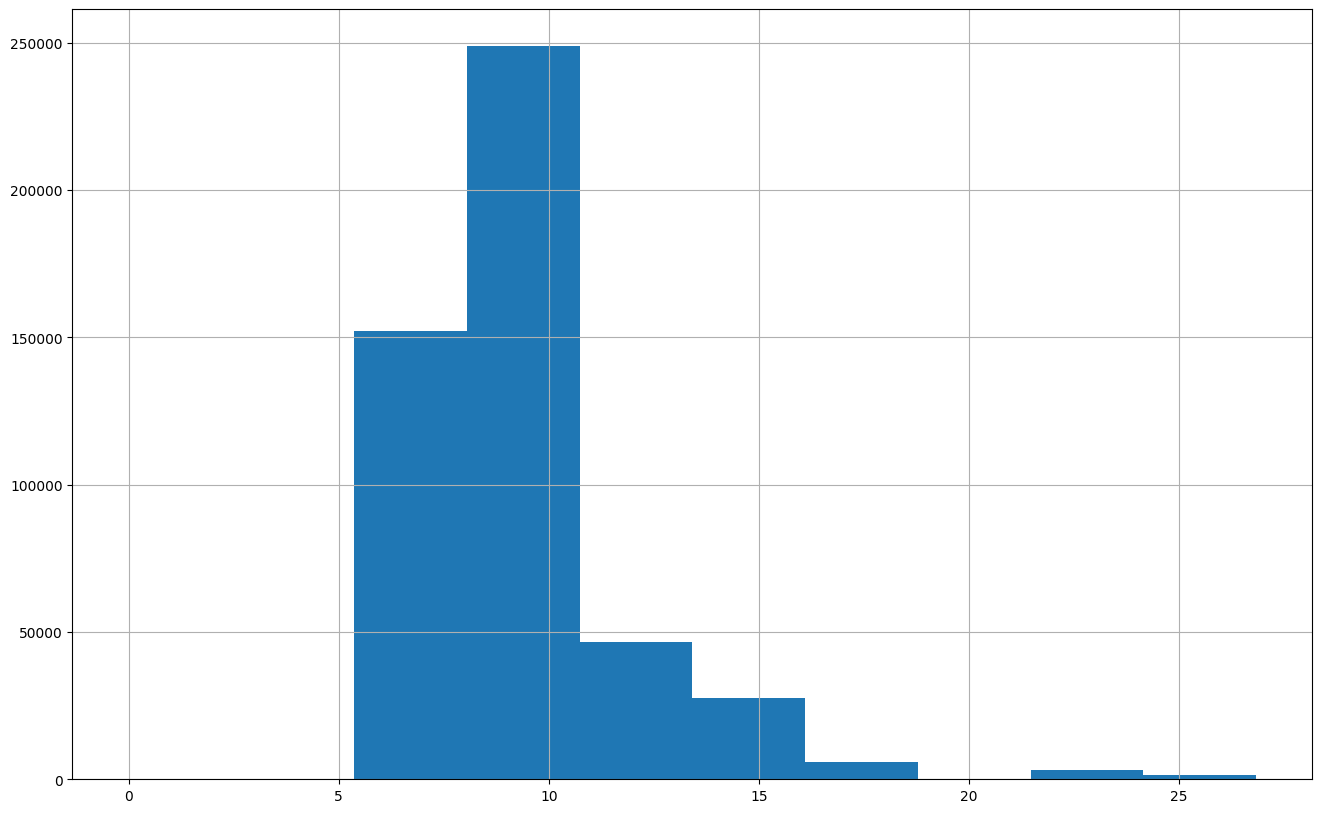

In [96]:
examples.dataframe.departure_mean_speed_1d.hist()

In [31]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [97]:
X = examples.dataframe.drop(["target", "_key", "_key_hash", "_subsort", "_time"], axis=1)
y = examples.dataframe["target"]


columns_to_encode = [
    'hvfhs_license_num', 'dispatching_base_num', 'originating_base_num', 
    'pu_location_id', 'do_location_id', 'shared_request_flag', 'shared_match_flag', 
    'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag', 'pu_zone', 'pu_borough', 
    'do_zone', 'do_borough', 'monthday', 
]
ct = ColumnTransformer(
    [('encoder', OneHotEncoder(sparse=False), columns_to_encode)],
    remainder='passthrough' 
)
X = ct.fit_transform(X)

Xtr, Xv, ytr, yv = train_test_split(X, y, train_size=50000, test_size=10000, random_state=42)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.7, 'max_depth': 5,
            'subsample': 0.7, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree',
            'eval_metric': 'rmsle', 'objective': 'reg:linear'}

# 0.28976 leader, 0.37195 10%
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

ValueError: A given column is not a column of the dataframe
